In [22]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/ICBHI_final_database.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ICBHI_extracted')

print(" Extraction complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Extraction complete.


In [33]:
import pandas as pd

# Define icbhi_df by calling the parsing function
icbhi_df = parse_icbhi_annotations(ICBHI_ANN_DIR)

disease_df = pd.read_csv("/content/drive/MyDrive/Diseases.txt",
                         sep="\t", header=None, names=["patient_id", "diagnosis"])

disease_df['patient_id'] = disease_df['patient_id'].astype(str)
icbhi_df['patient_id'] = icbhi_df['patient_id'].astype(str)

icbhi_df = icbhi_df.merge(disease_df, on="patient_id", how="left")

icbhi_df[['basename', 'label', 'diagnosis']].head()

,basename,label,diagnosis
0,174_1p2_Pr_mc_AKGC417L.wav,wheeze,COPD
1,174_1p2_Pr_mc_AKGC417L.wav,crackle,COPD
2,174_1p2_Pr_mc_AKGC417L.wav,crackle,COPD
3,174_1p2_Pr_mc_AKGC417L.wav,crackle,COPD
4,174_1p2_Pr_mc_AKGC417L.wav,crackle,COPD


In [24]:
icbhi_df['diagnosis'].value_counts()

,count
diagnosis,
COPD,5746
Healthy,322
Pneumonia,285
URTI,243
Bronchiolitis,160
Bronchiectasis,104
LRTI,32
Asthma,6


In [25]:
import os
import pandas as pd

ICBHI_ROOT = "/content/ICBHI_extracted/ICBHI_final_database"
ICBHI_WAV_DIR = ICBHI_ROOT
ICBHI_ANN_DIR = ICBHI_ROOT

def parse_icbhi_annotations(ann_dir):
    records = []
    for fname in os.listdir(ann_dir):
        if not fname.endswith(".txt"): continue
        full_path = os.path.join(ann_dir, fname)
        basename = fname.replace(".txt", ".wav")
        patient_id = basename.split('_')[0]
        with open(full_path, "r") as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 4 or not parts[0].replace('.', '', 1).isdigit(): continue
                start, end, c, w = float(parts[0]), float(parts[1]), int(parts[2]), int(parts[3])
                if c == 0 and w == 0:
                    label = "normal"
                elif c == 1 and w == 0:
                    label = "crackle"
                elif c == 0 and w == 1:
                    label = "wheeze"
                else:
                    label = "both"
                records.append({
                    "basename": basename,
                    "start": start,
                    "end": end,
                    "crackle": c,
                    "wheeze": w,
                    "label": label,
                    "patient_id": patient_id
                })
    return pd.DataFrame(records)

icbhi_df = parse_icbhi_annotations(ICBHI_ANN_DIR)
print(f" Parsed {len(icbhi_df)} respiratory cycles.")
icbhi_df.head()

 Parsed 6898 respiratory cycles.


,basename,start,end,crackle,wheeze,label,patient_id
0,174_1p2_Pr_mc_AKGC417L.wav,0.593,3.331,0,1,wheeze,174
1,174_1p2_Pr_mc_AKGC417L.wav,3.331,7.170,1,0,crackle,174
2,174_1p2_Pr_mc_AKGC417L.wav,7.170,11.027,1,0,crackle,174
3,174_1p2_Pr_mc_AKGC417L.wav,11.027,15.351,1,0,crackle,174
4,174_1p2_Pr_mc_AKGC417L.wav,15.351,19.240,1,0,crackle,174


In [26]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000

examples = {}
for label in ['normal', 'crackle', 'wheeze', 'both']:
    row = icbhi_df[icbhi_df['label'] == label].iloc[0]
    examples[label] = {
        "path": os.path.join(ICBHI_WAV_DIR, row['basename']),
        "start": row['start'],
        "end": row['end']
    }

def load_cycle_segment(path, start, end, sr=SAMPLE_RATE):
    y, _ = librosa.load(path, sr=sr)
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    return y[start_sample:end_sample]

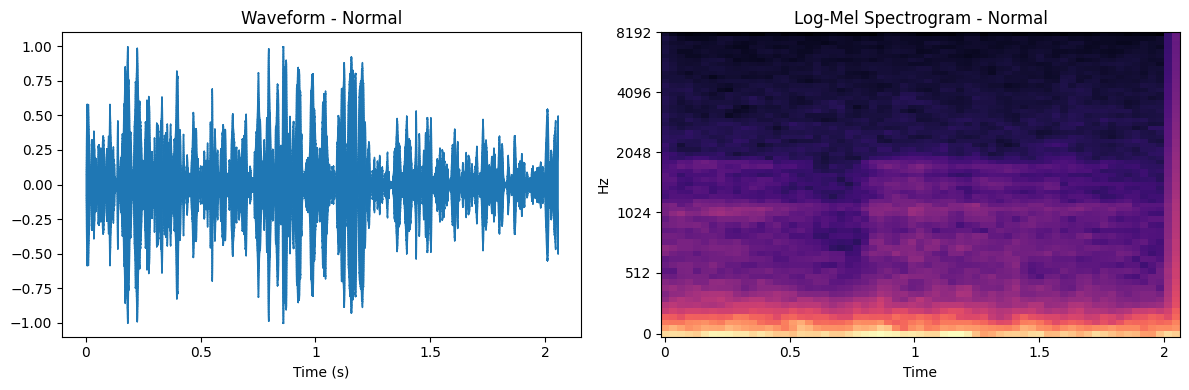

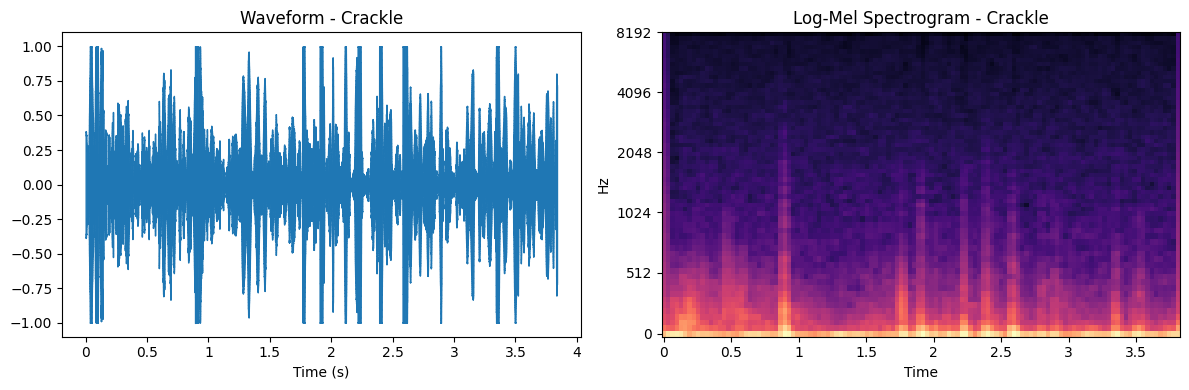

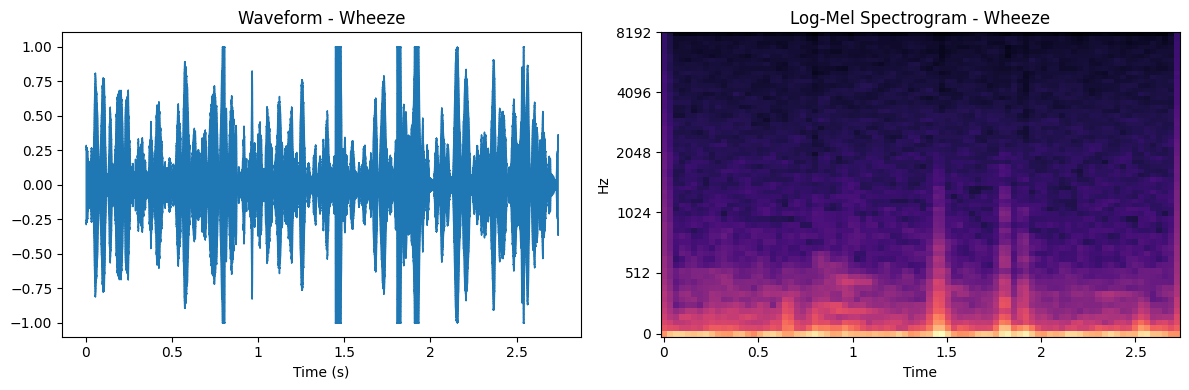

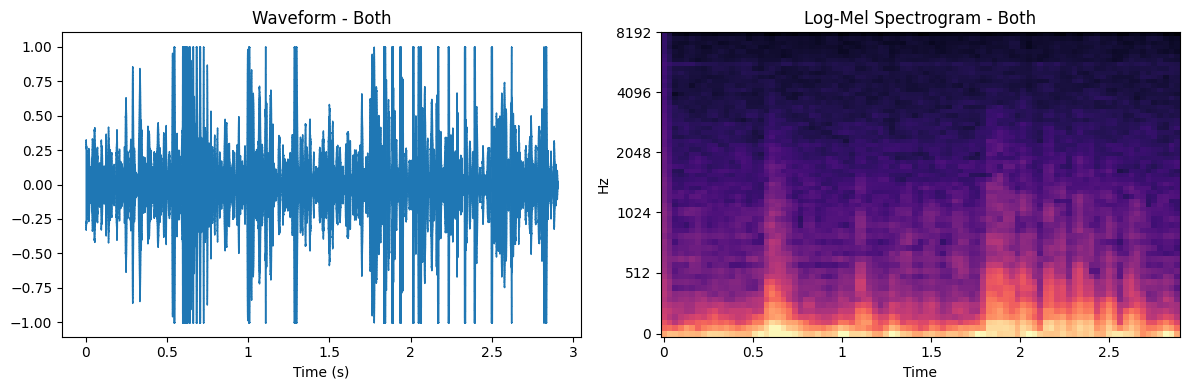

In [27]:
for label, info in examples.items():
    y = load_cycle_segment(info["path"], info["start"], info["end"])

    plt.figure(figsize=(12, 4))

    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=SAMPLE_RATE)
    plt.title(f"Waveform - {label.capitalize()}")
    plt.xlabel("Time (s)")

    # Log-mel spectrogram
    plt.subplot(1, 2, 2)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=64)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_db, sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
    plt.title(f"Log-Mel Spectrogram - {label.capitalize()}")

    plt.tight_layout()
    plt.show()

 Duration Statistics per Class:
           count      mean       std    min       25%      50%      75%  \
label                                                                    
both      506.0  3.059822  1.092131  0.571  2.238000  2.90385  3.55825   
crackle  1864.0  2.784554  0.952384  0.367  2.137000  2.62885  3.44900   
normal   3642.0  2.606978  1.275391  0.200  1.715875  2.44300  3.28800   
wheeze    886.0  2.702957  1.143494  0.228  1.803000  2.58450  3.35700   

             max  
label             
both      8.5917  
crackle   8.7360  
normal   16.1630  
wheeze    9.2170  


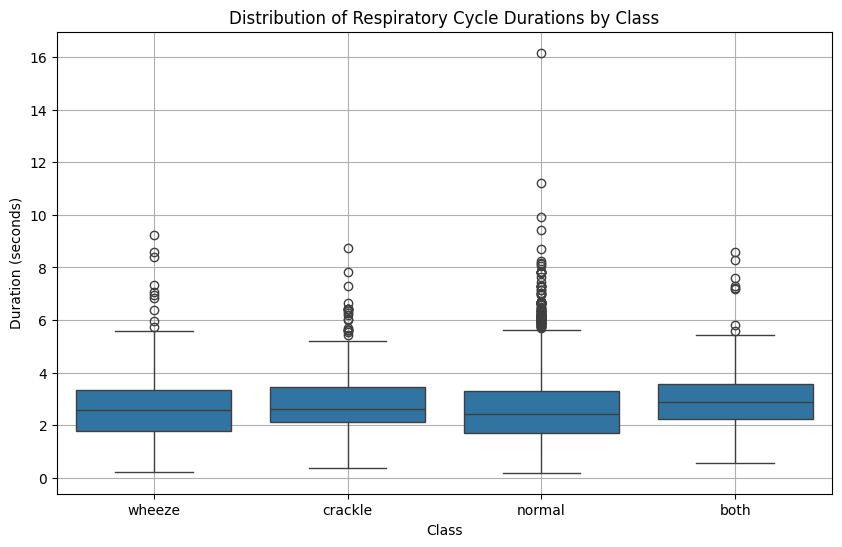


 Class Distribution:
 label
normal     3642
crackle    1864
wheeze      886
both        506
Name: count, dtype: int64


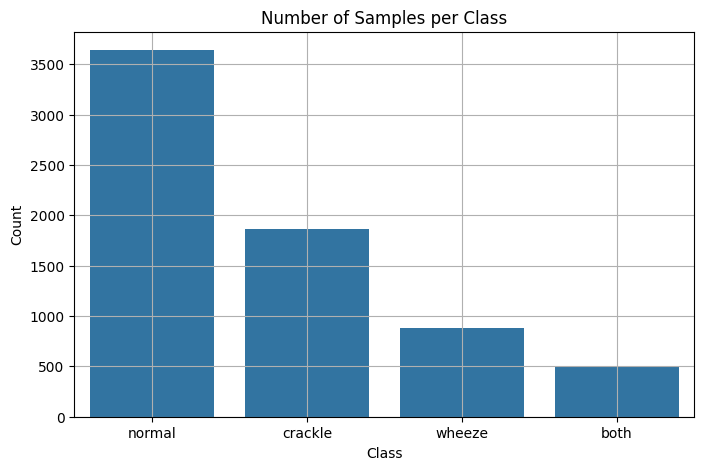

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt


icbhi_df['duration'] = icbhi_df['end'] - icbhi_df['start']


duration_stats = icbhi_df.groupby('label')['duration'].describe()
print(" Duration Statistics per Class:\n", duration_stats)


plt.figure(figsize=(10,6))
sns.boxplot(data=icbhi_df, x='label', y='duration')
plt.title("Distribution of Respiratory Cycle Durations by Class")
plt.ylabel("Duration (seconds)")
plt.xlabel("Class")
plt.grid(True)
plt.show()


label_counts = icbhi_df['label'].value_counts()
print("\n Class Distribution:\n", label_counts)

#  Plot Class Distribution
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Number of Samples per Class")
plt.ylabel("Count")
plt.xlabel("Class")
plt.grid(True)
plt.show()

In [31]:
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

SAMPLE_RATE = 16000
N_MELS = 128


spectrogram_variances = []
labels = []

print(" Calculating log-mel spectrogram variance per respiratory cycle...")

for idx, row in tqdm(icbhi_df.iterrows(), total=len(icbhi_df)):
    try:
        path = os.path.join(ICBHI_WAV_DIR, row['basename'])
        y, _ = librosa.load(path, sr=SAMPLE_RATE)
        start_sample = int(row['start'] * SAMPLE_RATE)
        end_sample = int(row['end'] * SAMPLE_RATE)
        y_seg = y[start_sample:end_sample]


        mel_spec = librosa.feature.melspectrogram(y=y_seg, sr=SAMPLE_RATE, n_mels=N_MELS)
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)


        variance = np.var(log_mel)

        spectrogram_variances.append(variance)
        labels.append(row['label'])
    except Exception as e:

        continue


import pandas as pd
var_df = pd.DataFrame({
    'label': labels,
    'spectrogram_variance': spectrogram_variances
})

 Calculating log-mel spectrogram variance per respiratory cycle...


100%|██████████| 6898/6898 [03:57<00:00, 29.03it/s]


/tmp/ipython-input-3478510506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=var_df, x='label', y='spectrogram_variance', palette="Set2")


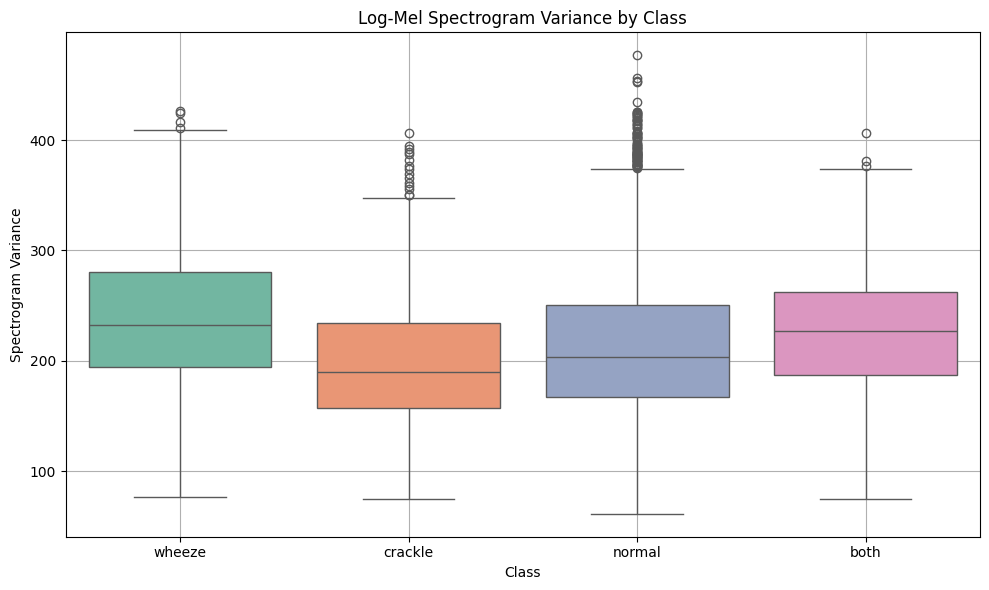

In [32]:
plt.figure(figsize=(10,6))
sns.boxplot(data=var_df, x='label', y='spectrogram_variance', palette="Set2")
plt.title("Log-Mel Spectrogram Variance by Class")
plt.xlabel("Class")
plt.ylabel("Spectrogram Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Define icbhi_df by calling the parsing function
icbhi_df = parse_icbhi_annotations(ICBHI_ANN_DIR)

disease_df = pd.read_csv("/content/drive/MyDrive/Diseases.txt",
                         sep="\t", header=None, names=["patient_id", "diagnosis"])

disease_df['patient_id'] = disease_df['patient_id'].astype(str)
icbhi_df['patient_id'] = icbhi_df['patient_id'].astype(str)

icbhi_df = icbhi_df.merge(disease_df, on="patient_id", how="left")

icbhi_df[['basename', 'label', 'diagnosis']].head()

In [34]:
sorted(icbhi_df['diagnosis'].dropna().unique())

['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']


 Showing audio for: Asthma


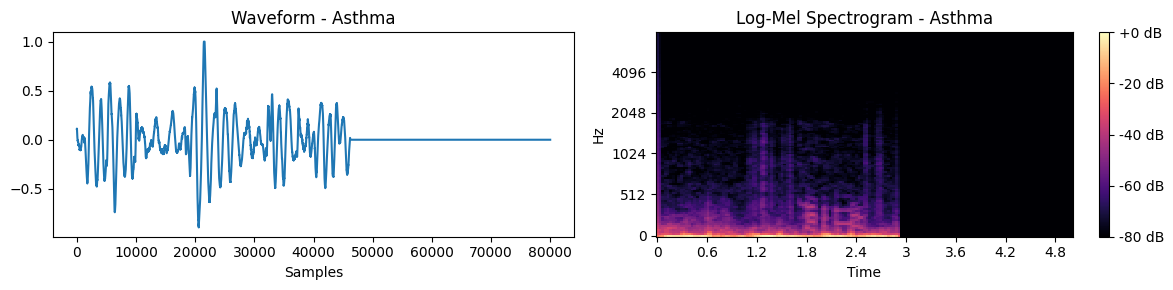


 Showing audio for: Bronchiectasis


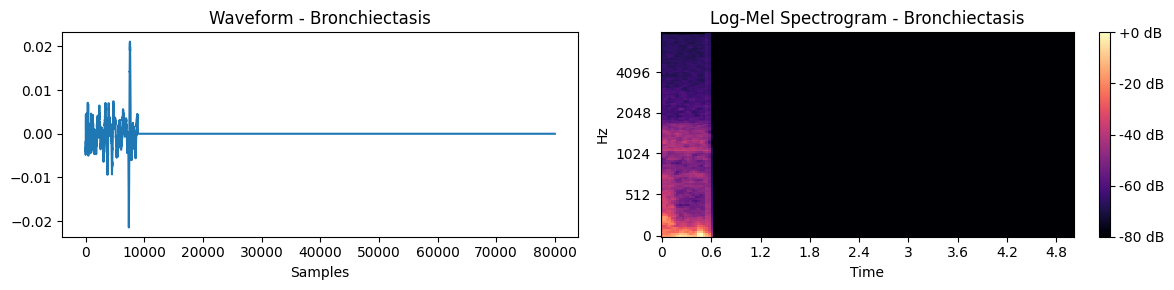


 Showing audio for: Bronchiolitis


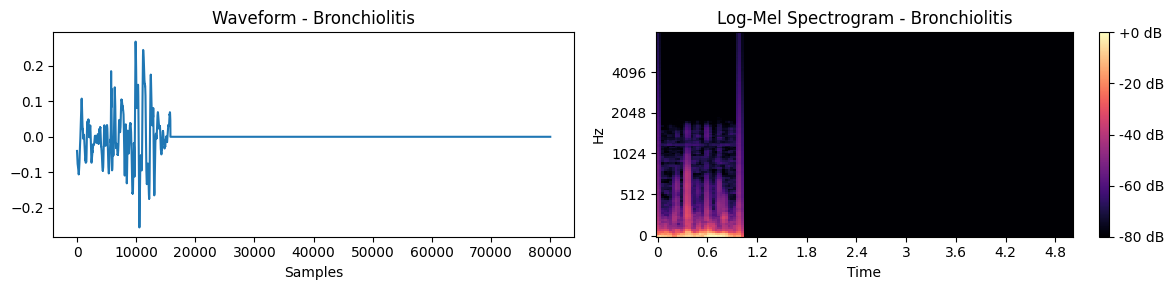


 Showing audio for: COPD


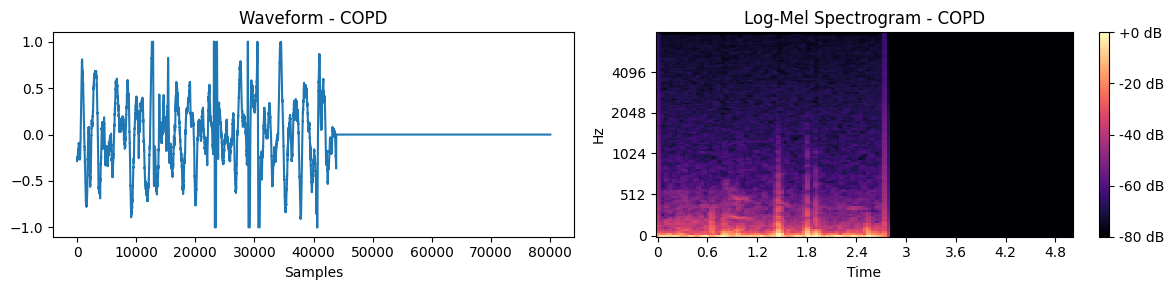


 Showing audio for: Healthy


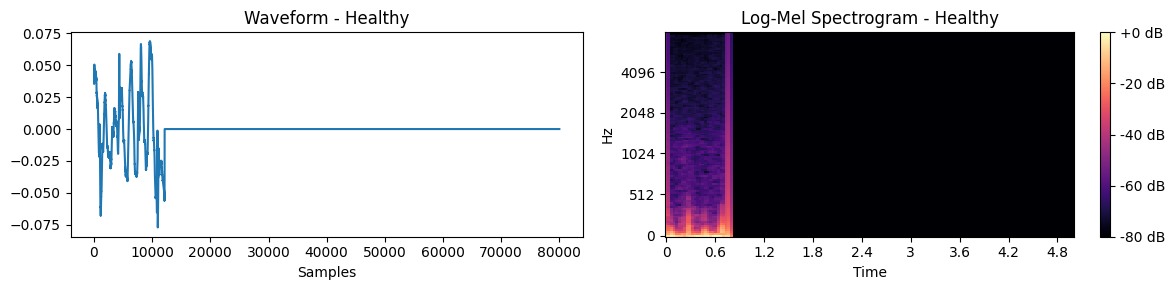


 Showing audio for: LRTI


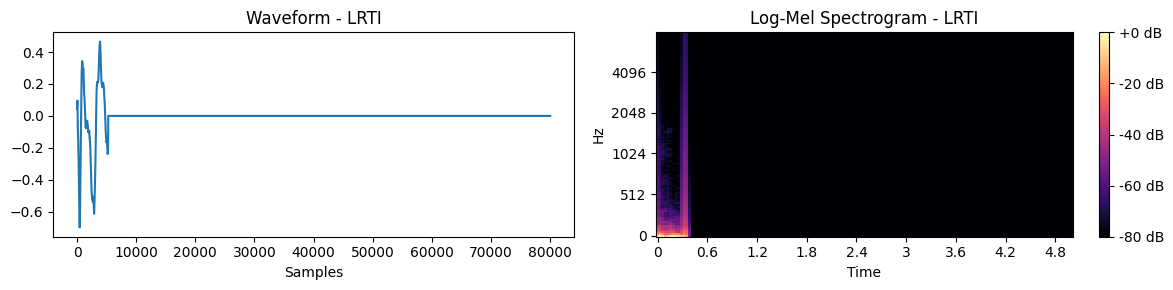


 Showing audio for: Pneumonia


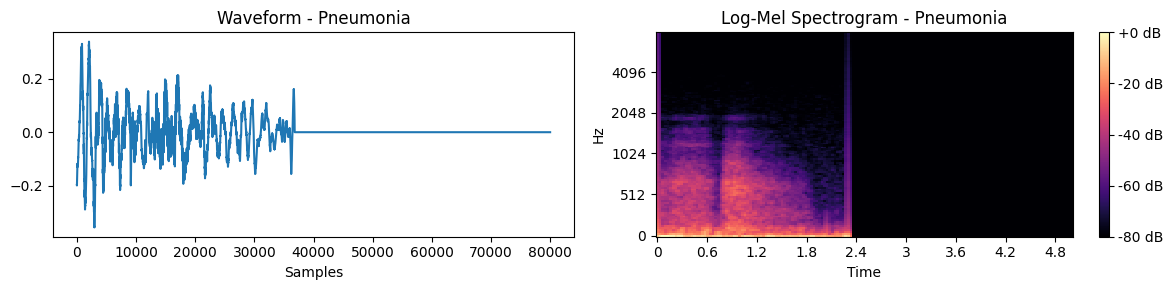


 Showing audio for: URTI


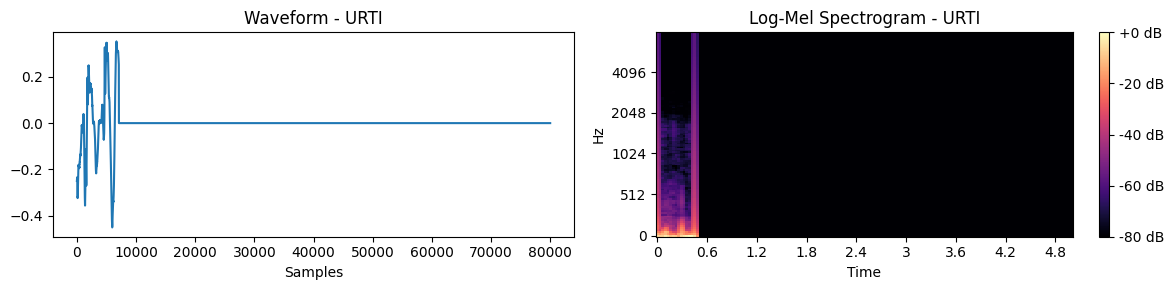

In [35]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os


all_diseases = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']
SR = 16000
SECONDS = 5  # Duration to crop/pad for consistent visuals

def plot_example_for_disease(disease):

    row = icbhi_df[icbhi_df['diagnosis'] == disease].iloc[0]
    file_path = os.path.join("/content/ICBHI_extracted/ICBHI_final_database", row['basename'])

    y, sr = librosa.load(file_path, sr=SR)
    start_sample = int(row['start'] * SR)
    end_sample = int(row['end'] * SR)
    y_seg = y[start_sample:end_sample]

    target_len = SR * SECONDS
    if len(y_seg) < target_len:
        y_seg = np.pad(y_seg, (0, target_len - len(y_seg)))
    else:
        y_seg = y_seg[:target_len]


    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    axs[0].plot(y_seg)
    axs[0].set_title(f"Waveform - {disease}")
    axs[0].set_xlabel("Samples")

    mel_spec = librosa.feature.melspectrogram(y=y_seg, sr=SR, n_mels=128)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(log_mel, sr=SR, x_axis="time", y_axis="mel", ax=axs[1])
    axs[1].set_title(f"Log-Mel Spectrogram - {disease}")
    fig.colorbar(img, ax=axs[1], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()


for disease in all_diseases:
    print(f"\n Showing audio for: {disease}")
    plot_example_for_disease(disease)